# Análisis de la calidad de datos abiertos de personal del portal de datos abiertos del CPLT

### ¿Qué tan uniformes son los campos de las distintas fuentes de datos abiertos de la contratación de personal?

In [101]:
import pandas as pd
# importamos las columnas de cada archivo
col_planta = pd.read_csv('G:/temp/planta.csv', nrows=1, sep=',').keys().tolist()
col_contrata = pd.read_csv('G:/temp/contrata.csv', nrows=1, sep=',').keys().tolist()
col_honorarios = pd.read_csv('G:/temp/honorarios.csv', nrows=1, sep=',').keys().tolist()
col_codigo = pd.read_csv('G:/temp/codTrabajo.csv', nrows=1, sep=',').keys().tolist()

# unimos las columnas en una lista
cols = [col_planta, col_contrata, col_honorarios, col_codigo]

# loop para revisar cuales son todos los campos
col_t = []
for l in cols:
    for col in l:
        if col not in col_t:
            col_t.append(col)
            
# se almacena en un dataframe
dfcols = pd.DataFrame(col_t, columns =['Campos'])

# se crean los otros dataframes para luego hacer un merge
dfs = ['dfplanta', 'dfcontrata', 'dfhonorarios', 'dfcodigo']
datasets = ['Planta', 'Contrata', 'Honorarios', 'Codigo del trabajo']

a = zip(dfs, cols)

lista_dfs = {}
for df, file in a:
    lista_dfs[df] = pd.DataFrame(file, columns=['Campos'])
    lista_dfs[df]['Existe'] = 'Si'
    
for i, dfs in enumerate(lista_dfs):
    dfcols = dfcols.merge(lista_dfs[dfs], how='left').rename(columns={'Existe':datasets[i]})
dfcols = dfcols.fillna('No')

dfcols

,Campos,Planta,Contrata,Honorarios,Codigo del trabajo
0,Unnamed: 0,Si,Si,Si,Si
1,camino,Si,Si,Si,Si
2,organismo_nombre,Si,Si,Si,Si
3,organismo_codigo,Si,Si,Si,Si
4,fecha_publicacion,Si,Si,Si,Si
5,anyo,Si,Si,Si,Si
6,Mes,Si,Si,Si,Si
7,Tipo Estamento,Si,Si,No,No
8,Nombres,Si,Si,Si,Si
9,Paterno,Si,Si,Si,Si


### ¿Cuál es el campo que indica la fecha o periódo de publicación?

In [102]:
#Importamos las credenciales que usaremos en todo el notebook para conectarnos al ambiente de vertica
import os
import vertica_python
import pandas as pd

user = os.getenv('vertuser')
passwd = os.getenv('vertpass')
host = os.getenv('verthost')
db = os.getenv('vertdb')
port = os.getenv('vertport')

# información de conexión a vertica
conn_info = {'host': host,
             'port': port,
             'user': user,
             'password': passwd,
             'database': db,
             'unicode_error': 'strict',
             'ssl': False,
             'use_prepared_statements': False}

In [103]:
# conexión simple con cierre manual
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query1 = '''
SELECT round(SUM(año)/count(año), 4) * 100 as '% en que no coincide año', 
round(SUM(Mes)/count(Mes), 4) * 100 as '% en que no coincide mes',
round(SUM(Ambos)/count(Ambos), 4) * 100 as '% en que no coinciden ambos'
FROM (
SELECT 
CASE WHEN f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as año,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) then 0 else 1 end as Mes,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) and f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as Ambos
FROM funcionarios."full" f 
) as t
'''

df1 = pd.read_sql(query1, cnxn)

cnxn.close()
df1

,% en que no coincide año,% en que no coincide mes,% en que no coinciden ambos
0,99.67,92.06,100.0


### ¿Desde cuando se publica?

In [104]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query2 = '''
SELECT f.anyo as Año , f.Mes  as Mes , count(*) as 'Cantidad de registros'
FROM funcionarios."full" f 
GROUP BY f.anyo , f.Mes, mesN
order by f.anyo, mesN asc
'''

df2 = pd.read_sql(query2, con=cnxn)
# añadimos año-mes
df2['mesAño'] = df2['Año'].astype(str) + '-' + df2['Mes']

cnxn.close()

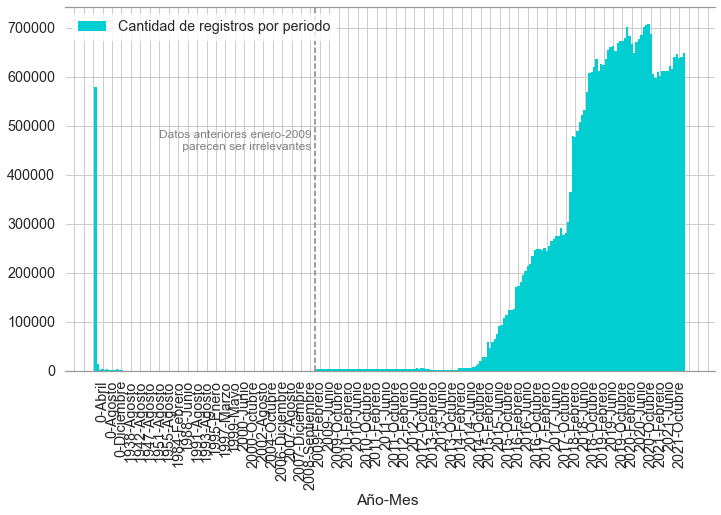

In [105]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fast')

y = df2['Cantidad de registros']
x = df2['mesAño']

fig, ax = plt.subplots(figsize=(10,6))
# ax.grid(visible=None)
plt.xticks(rotation=90)
plt.tight_layout() 
plt.bar(x, y, width=1, color='darkturquoise', edgecolor='none')
stepsize = 4
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax.set_xlabel('Año-Mes ')

# color de los ejes 
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(['Cantidad de registros por periodo'], loc = 'upper left', shadow = False, edgecolor = 'white')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2008-Diciembre'].index.values[0]], 450000,\
         'Datos anteriores enero-2009 \n parecen ser irrelevantes ', color = 'grey',\
        horizontalalignment='right', fontsize=12)

# plt.text(df2['mesAño'][df2[df2['mesAño'] == '2022-Enero'].index.values[0]], 650000,\
#          ' Datos posteriores a Julio-2021\n   parecen ser irrelevantes', color = 'grey',\
#         horizontalalignment='left', fontsize=12)

ax.axvline(x='2008-Diciembre', color = 'grey', ls = '--')
#ax.axvline(x='2022-Enero', color = 'grey', ls = '--')
plt.savefig('fig1.png', bbox_inches = 'tight')
plt.show()

### ¿Quienes publican periodos inconsistentes?

In [106]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query3 = '''
SELECT f.OrganismoCodigo, f.OrganismoNombre, count(distinct concat(f.anyo, f.Mes)) cant_periodos 
FROM funcionarios."full" f 
WHERE (f.anyo < 2009 or f.anyo > 2022)
GROUP  By f.OrganismoCodigo, f.OrganismoNombre
'''

df3 = pd.read_sql(query3, con=cnxn)

cnxn.close()
print(len(df3))
rank10 = df3.sort_values(by='cant_periodos', ascending=False).head(10).sort_values(by='cant_periodos')

656


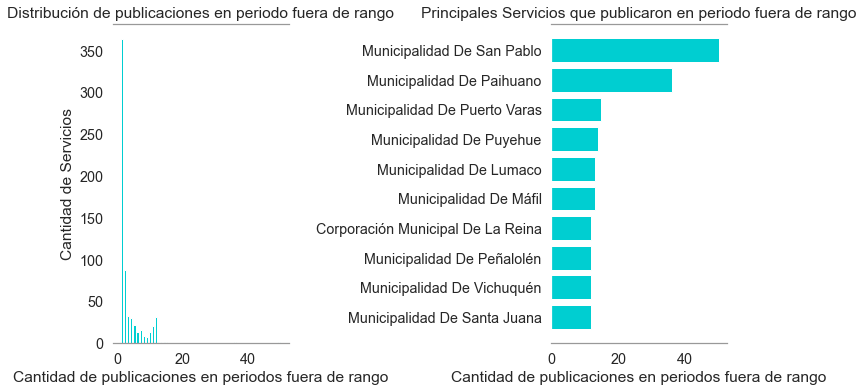

In [107]:
plt.rcParams.update({'font.size': 9})
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
y1 = rank10['OrganismoNombre']
x1 = rank10['cant_periodos']

x2 = df3['cant_periodos']
ax0.grid(visible=None)
ax1.grid(visible=None)
# color de los ejes 
ax0.spines['bottom'].set_color('#999')
ax0.spines['top'].set_color('#999') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

# color de los ejes 
ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')

ax0.hist(x2, bins = 51, color = 'darkturquoise', width=0.7)
ax0.set_title('Distribución de publicaciones en periodo fuera de rango')
ax0.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax0.set_ylabel('Cantidad de Servicios')

ax1.barh(y1, x1, color= 'darkturquoise')
ax1.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax1.set_title('Principales Servicios que publicaron en periodo fuera de rango')

plt.rcParams["font.family"] = "sans-serif"
fig.tight_layout(pad=3)
plt.savefig('fig2.png', bbox_inches = 'tight')
plt.show()

### ¿Cuándo se hicieron estos registros equivocados?

In [108]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query4 = '''
SELECT date(FechaPublicacion) fecha , count(distinct OrganismoCodigo ) cantidadservicios, count(f.FechaPublicacion) cantidadregistros
FROM funcionarios."full" f 
WHERE (f.anyo < 2009 or f.anyo > 2022)
GROUP  By date(FechaPublicacion)
'''
df4 = pd.read_sql(query4, con=cnxn)
df4.fecha = pd.to_datetime(df4['fecha'])
df4 = df4.sort_values(by=['fecha'])
cnxn.close()

In [109]:
df4.sort_values(by=['cantidadregistros'], ascending=False).head(5)

,fecha,cantidadservicios,cantidadregistros
38,2022-02-14,195,153061
20,2022-11-02,73,76711
11,2022-10-02,76,56003
46,2022-02-15,53,40704
10,2022-09-02,49,35442


In [110]:
df4.sort_values(by=['fecha'], ascending=False).tail(5)

,fecha,cantidadservicios,cantidadregistros
15,2021-12-13,1,434
43,2021-11-23,1,3
14,2021-03-12,1,299
22,2021-02-12,1,1
6,2020-11-29,1,1


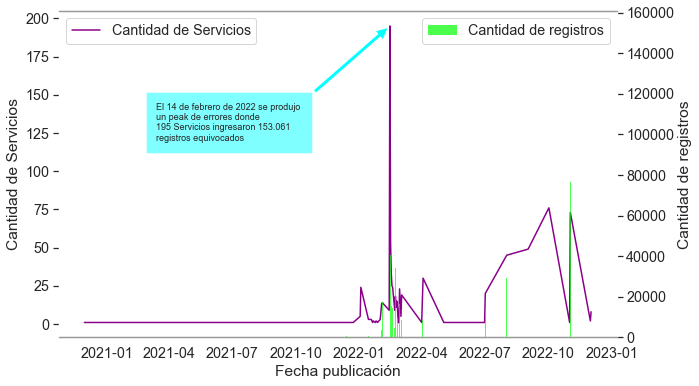

In [111]:
fig, ax = plt.subplots(figsize=(10,6))
ax1 = ax.twinx()
ax.plot(df4['fecha'], df4['cantidadservicios'], c='darkmagenta')
ax1.bar(df4['fecha'], df4['cantidadregistros'], alpha=0.7, color='lime', edgecolor='none')

ax.set(ylabel='Cantidad de Servicios')
ax.grid(visible=None)
ax1.set(ylabel='Cantidad de registros')
ax1.grid(visible=None)
ax.legend(['Cantidad de Servicios'], loc='upper left')
ax1.legend(['Cantidad de registros'], loc='upper right')

# color de los ejes 
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.set_xlabel('Fecha publicación')
ax.set_xlabel('Fecha publicación')
ax.annotate('El 14 de febrero de 2022 se produjo \nun peak de errores donde \n195 Servicios ingresaron 153.061 \nregistros equivocados', xy=(df4[df4['fecha']== '2022-02-14']['fecha'],195)
         , xytext=(df4[df4['fecha']== '2021-03-12']['fecha'],120), arrowprops=dict(facecolor='cyan',shrink=0.02, width=4 ), bbox={'facecolor': 'cyan', 'alpha': 0.5, 'pad': 10})

plt.savefig('fig3.png', bbox_inches = 'tight')
plt.show()

### ¿Cuáles son las instituciones que publican en el dataset?

In [112]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query5 = '''SELECT * FROM funcionarios.Servicios'''
df5 = pd.read_sql(query5, con=cnxn)
cnxn.close()
df5

,Codigo_org,idOrg,Organismo,Codigo_padre,Padre_org,Region,Municipalidad,direccion,telefono,url_organismo,...,banco,url_sai,fax,Ingresa,obligadorecibir_sai,organismo_autonomo,interopera,tiene_ta,fecha_ta,activado
0,AA001,757,Presidencia de la República,AA000,Presidencia de la República,Región Metropolitana de Santiago,SANTIAGO,Morandé #130,56 2 2690 4798,http://www.gobiernodechile.cl/,...,None,http://transparenciaactiva.presidencia.cl/,None,Ingresa,SÍ,NO,NO,SÍ,2018/11/16,SÍ
1,AB001,758,Subsecretaría del Interior,AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Teatinos N 92 piso 7 Edificio Moneda Bicentenario,224863520,http://www.interior.gob.cl/,...,None,https://siac.interior.gob.cl/formulario.gov?ac...,None,Ingresa,SÍ,NO,NO,SÍ,2021/09/13,SÍ
2,AB002,961,Subsecretaría de Desarrollo Regional y Adminis...,AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Teatinos N92 Piso 2 y 3.,26363600,http://www.subdere.cl/,...,None,http://www.subdere.gov.cl/transparencia/ley202...,None,Ingresa,SÍ,NO,NO,SÍ,2018/06/14,SÍ
3,AB003,962,Agencia Nacional de Inteligencia (ANI),AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Tenderini 115,56 2 2630 5000,http://,...,None,https://siac.interior.gob.cl/formulario.gov?ac...,None,Ingresa,SÍ,NO,NO,SÍ,None,SÍ
4,AB004,963,Oficina Nacional de Emergencia (ONEMI),AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Beaucheff 1671,222524369 222524370,http://www.onemi.cl/,...,None,https://siac.onemi.gov.cl,None,Ingresa,SÍ,NO,NO,SÍ,2018/01/01,SÍ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,UN014,1084,Universidad de La Frontera (UFRO),UN000,Universidades,Región de La Araucanía,TEMUCO,AV. FRANCISCO SALAZAR,(45) 325000,http://www.ufro.cl/,...,None,http://www2.ufro.cl/transparencia/,None,No ingresa,SÍ,NO,NO,NO,None,SÍ
1232,UN015,1077,Universidad de Los Lagos,UN000,Universidades,Región de Los Lagos,OSORNO,AV. FUCHSLOCHER 1305 OSORNO,(64) 333 000,http://www.ulagos.cl/,...,None,http://transparencia.ulagos.cl/?page_id=81,None,No ingresa,SÍ,NO,NO,NO,None,SÍ
1233,UN016,1078,Universidad de Magallanes,UN000,Universidades,Región de Magallanes y de la Antártica Chilena,PUNTA ARENAS,Oficina de Partes AV. BULNES 01855 PUNTA ARENAS,(61) 2207000,http://www.umag.cl/,...,None,http://analisis.umag.cl/transparencia/solicitu...,None,Ingresa,SÍ,NO,NO,NO,None,SÍ
1234,UN017,58901,Universidad de Aysén,UN000,Universidades,Región de Aysén del General Carlos Ibáñez del ...,COYHAIQUE,Obispo Vielmo N62 Coyhaique,+56 67 2332201,http://www.uaysen.cl/,...,None,http://www.uaysen.cl/,None,Ingresa,SÍ,NO,NO,SÍ,2018/01/01,SÍ


In [113]:
display(pd.crosstab(df5["obligadorecibir_sai"],df5["Ingresa"], 
values=df5["Codigo_org"],aggfunc='count'))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["Ingresa"], 
values=df5["Codigo_org"],aggfunc='count', normalize=True))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["interopera"], 
values=df5["Codigo_org"],aggfunc='count'))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["interopera"], 
values=df5["Codigo_org"],aggfunc='count', normalize=True))

Ingresa,Ingresa,No ingresa
obligadorecibir_sai,,
NO,2,91
SÍ,793,350


Ingresa,Ingresa,No ingresa
obligadorecibir_sai,,
NO,0.001618,0.073625
SÍ,0.641586,0.283172


interopera,NO,SÍ
obligadorecibir_sai,,
NO,93.0,NaN
SÍ,1141.0,2.0


interopera,NO,SÍ
obligadorecibir_sai,,
NO,0.075243,0.000000
SÍ,0.923139,0.001618


### De los servicios obligados ¿Cuáles agrupaciones Ingresan?

In [114]:
dfobligados = df5[df5['obligadorecibir_sai'] == 'SÍ']

In [115]:
dftemp =pd.crosstab(dfobligados["Padre_org"],dfobligados["Ingresa"], 
values=dfobligados["Codigo_org"],aggfunc='count').fillna(0)
dftemp["Total"] = dftemp['Ingresa'] + dftemp['No ingresa']
dftemp= dftemp.reset_index().sort_values(by=['Total'])
dftemp.to_excel('temp.xlsx')

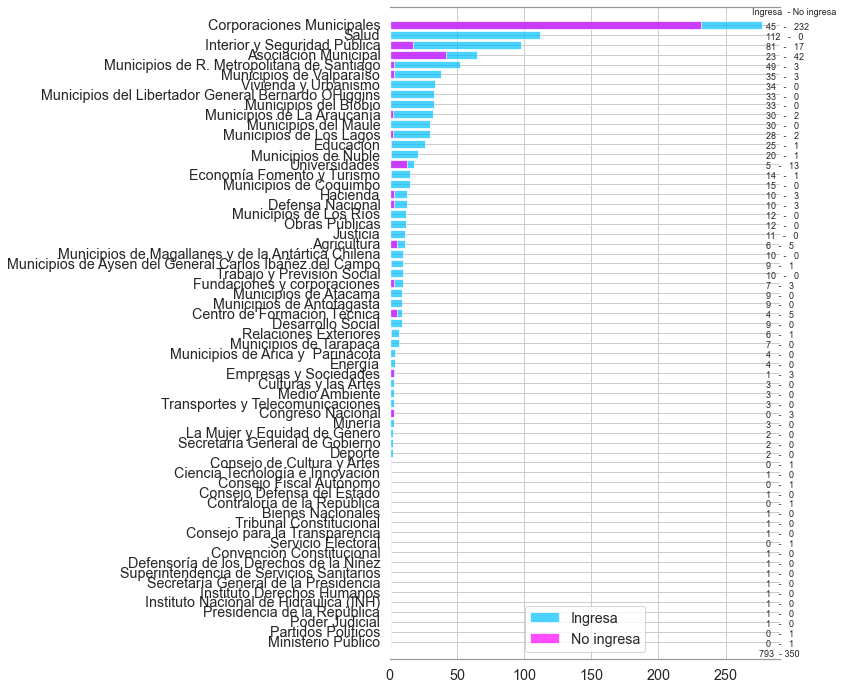

In [116]:
fig, ax = plt.subplots(figsize=(7,12))
p1 = ax.barh(dftemp['Padre_org'], dftemp['Total'], alpha=0.7, color='deepskyblue')
p2 = ax.barh(dftemp['Padre_org'], dftemp['No ingresa'], alpha=0.7, color='fuchsia')
for i, row in enumerate(dftemp['Padre_org']):
    ax.text(280, i-0.5, str(list(dftemp[dftemp['Padre_org']==row]['Ingresa'].astype(int))[0]) + '   -   '+ str(list(dftemp[dftemp['Padre_org']==row]['No ingresa'].astype(int))[0]) )

ax.text(270, 63, 'Ingresa  - No ingresa')
ax.text(275, -1.5, '793  - 350')
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.margins(y = 0.022)
plt.legend(['Ingresa', 'No ingresa'], loc='lower center')
plt.savefig('fig4.png', bbox_inches = 'tight')
plt.show()

### Cantidad de Servicios que han informado

In [117]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query6 = '''
SELECT DISTINCT f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, f.OrganismoCodigo, s.obligadorecibir_sai, s.Ingresa 
FROM funcionarios."full" f
LEFT JOIN funcionarios.Servicios s ON f.OrganismoCodigo =s.Codigo_org 
WHERE f.anyo  > 2012
'''

df6 = pd.read_sql(query6, con=cnxn)

cnxn.close()

df6 = df6.drop(columns = ['OrganismoCodigo'])
df6['Año-Mes']  = df6['anyo'].astype(str) + '-' + df6['mesN']


In [118]:
df6['Fecha'] = pd.to_datetime(df6['Año-Mes'])
df6 = df6.sort_values(by=['Fecha'])

In [119]:
ticksdf = df6['Año-Mes'].drop_duplicates().reset_index(drop=True).reset_index()

In [120]:
ticks = pd.DataFrame([n for n in range(1, 122, 4)]).rename(columns={0:'col'})
ticksf = ticks.merge(ticksdf, left_on='col', right_on='index')


In [121]:
df6.groupby(by=['Año-Mes', 'Ingresa'])['Padre_org'].count()

Año-Mes  Ingresa   
2013-01  Ingresa         6
2013-02  Ingresa         7
2013-03  Ingresa         8
2013-04  Ingresa         7
2013-05  Ingresa         7
                      ... 
2021-10  No ingresa     26
2021-11  Ingresa       628
         No ingresa     27
2021-12  Ingresa       617
         No ingresa     24
Name: Padre_org, Length: 181, dtype: int64

<Figure size 720x504 with 0 Axes>

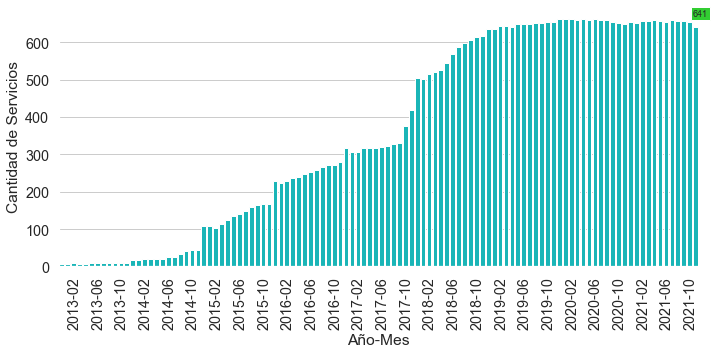

In [122]:
import seaborn as sns
plt.figure(figsize=(10,7))
g1 = sns.catplot(kind='count', ci=None, data=df6, x='Año-Mes', aspect=2, color='darkturquoise')
g1.set_xticklabels(rotation=90, ha='left')
ax = g1.axes.flat
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[0].annotate('641', xy=(106.5,670), bbox={'facecolor': 'limegreen', 'alpha': 1, 'pad': 2})
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.tight_layout()
plt.savefig('fig5.png', bbox_inches = 'tight')
plt.show()

<Figure size 720x720 with 0 Axes>

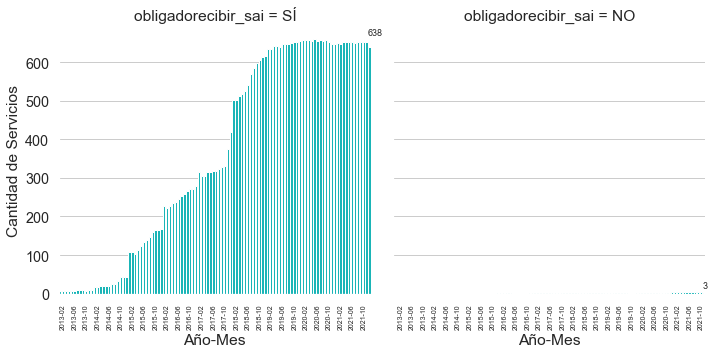

In [123]:
import matplotlib
plt.figure(figsize=(10,10))
g1 = sns.catplot(kind='count', data=df6, x='Año-Mes', col="obligadorecibir_sai", aspect=1, color='darkturquoise')
g1.set_xticklabels(rotation=90, fontsize=7)
ax = g1.axes.flat
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[1].spines['bottom'].set_color('white')
ax[0].annotate('638', xy=(106.5,670))
ax[1].annotate('3', xy=(106.5,15))
plt.tight_layout()
plt.savefig('fig6.png', bbox_inches = 'tight')

plt.show()

<Figure size 720x504 with 0 Axes>

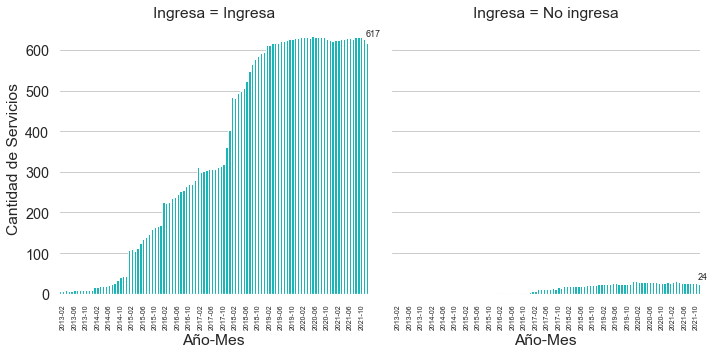

In [124]:
plt.figure(figsize=(10,7))
g2 = sns.catplot(kind='count', data=df6, x='Año-Mes', col="Ingresa", aspect=1, color='darkturquoise')
g2.set_xticklabels(rotation=90, fontsize=7)
ax = g2.axes.flat
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[1].spines['bottom'].set_color('white')
ax[0].annotate('617', xy=(106.5,635))
ax[1].annotate('24', xy=(106.5,35))
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.tight_layout()
plt.savefig('fig7.png', bbox_inches = 'tight')
plt.show()

In [125]:
df6.groupby(by=['Año-Mes', 'Ingresa'])['Padre_org'].count()

Año-Mes  Ingresa   
2013-01  Ingresa         6
2013-02  Ingresa         7
2013-03  Ingresa         8
2013-04  Ingresa         7
2013-05  Ingresa         7
                      ... 
2021-10  No ingresa     26
2021-11  Ingresa       628
         No ingresa     27
2021-12  Ingresa       617
         No ingresa     24
Name: Padre_org, Length: 181, dtype: int64

### ¿quienes no publicaron el dato de abril?

In [126]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query7 = '''
SELECT DISTINCT f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, s.Organismo, s.obligadorecibir_sai, s.Ingresa, count(f.nombre ) cantidad_informada
FROM funcionarios."full" f
LEFT JOIN funcionarios.Servicios s ON f.OrganismoCodigo =s.Codigo_org 
WHERE f.anyo  > 2012
GROUP BY f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, s.Organismo, s.obligadorecibir_sai, s.Ingresa
'''

df7 = pd.read_sql(query7, con=cnxn)

cnxn.close()

df7['Año-Mes']  = df7['anyo'].astype(str) + '-' + df7['mesN']
df7['fecha'] = pd.to_datetime(df7['Año-Mes'])

In [127]:
dfmarzo = df7[df7['fecha']<='2021-11-01']
dfabril = df7[df7['fecha']=='2021-12-01']
marzo_unicos = dfmarzo[['OrganismoCodigo', 'Organismo']].drop_duplicates()
abril_unicos = dfabril[['OrganismoCodigo', 'Organismo']].drop_duplicates()
noreportaron = pd.merge(marzo_unicos, abril_unicos, how='left', left_on='OrganismoCodigo', right_on='OrganismoCodigo')
noreportaron = noreportaron[noreportaron['Organismo_y'].isna()].drop(columns=['Organismo_y'])
noreportaron['Reporta Abril'] = 'No'
noreportaron.to_excel('noreportaron.xlsx')

In [128]:
dfabrilbox = pd.merge(df7, noreportaron, how='left', left_on='OrganismoCodigo', right_on='OrganismoCodigo').drop(columns=['Organismo_x'])
dfabrilbox['Reporta Abril'] = dfabrilbox['Reporta Abril'].fillna('Si')
dfabrilbox = dfabrilbox.groupby(by=['OrganismoCodigo', 'Organismo', 'Reporta Abril'])['cantidad_informada'].mean().reset_index()
dfabrilbox.sort_values(by=['cantidad_informada'], ascending=False)

,OrganismoCodigo,Organismo,Reporta Abril,cantidad_informada
356,FU001,Fundación Integra,Si,24562.000000
80,AJ010,Junta Nacional de Jardines Infantiles (JUNJI),Si,19806.785714
611,MU233,Municipalidad de Puerto Montt,Si,8432.710526
677,MU308,Municipalidad de Santiago,Si,7415.186047
681,MU312,Municipalidad de Talca,Si,6433.458333
...,...,...,...,...
363,MA004,Asociación de Municipios de La Región de Los Ríos,Si,1.034483
406,MA058,Asociación de Municipalidades Cordilleranas de...,No,1.000000
407,MA063,Asociación de Municipalidades para la Segurida...,No,1.000000
375,MA017,Asociación de Municipalidades Desarrollo Apicu...,No,1.000000


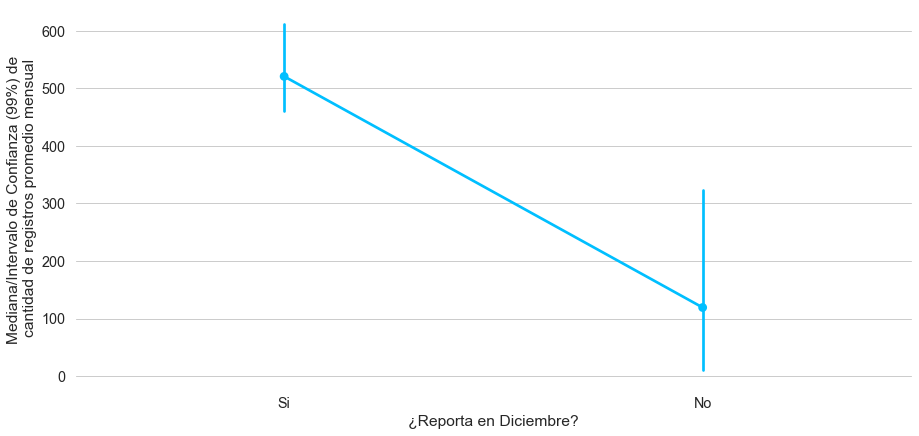

In [155]:
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
g7 = sns.pointplot(x='Reporta Abril', y='cantidad_informada', data=dfabrilbox, estimator=np.median, ci=99, label='big', color='deepskyblue')
g7.set_xlabel('¿Reporta en Diciembre?')
g7.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de registros promedio mensual')
g7.spines['left'].set_color('white')
g7.spines['right'].set_color('white')
g7.spines['top'].set_color('white')
g7.spines['bottom'].set_color('white')
plt.savefig('fig8.png', bbox_inches = 'tight')
plt.show()

### Regularidad de Publicación de los Servicios Obligados

In [130]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
qPeriodos = '''
SELECT anyo , mesN , OrganismoCodigo as organismo_codigo , OrganismoNombre as organismo_nombre  
FROM funcionarios."full" f 
WHERE f.anyo  > 2012
'''

dfPer = pd.read_sql(qPeriodos, con=cnxn)

cnxn.close()

In [131]:
#Variable año mes
dfPer['fecha'] = pd.to_datetime(dfPer['anyo'].astype(str)+'/'+dfPer['mesN'].astype(str))

In [132]:
#Calculo de periodos que debería haber publicado
dfMesIni = dfPer.groupby(by=['organismo_codigo'])['fecha'].min().reset_index()
dfMesIni['max'] = pd.to_datetime('2021-12-01')
dfMesIni['diff'] = (dfMesIni['max'] - dfMesIni['fecha'])
dfMesIni['diff'] = round(dfMesIni['diff']/np.timedelta64(1,'M') + 1)

In [133]:
dfMesIni

,organismo_codigo,fecha,max,diff
0,AA001,2018-10-01,2021-12-01,39.0
1,AB001,2021-08-01,2021-12-01,5.0
2,AB002,2018-04-01,2021-12-01,45.0
3,AB004,2017-11-01,2021-12-01,50.0
4,AB075,2019-08-01,2021-12-01,29.0
...,...,...,...,...
709,MU344,2015-05-01,2021-12-01,80.0
710,MU345,2016-01-01,2021-12-01,72.0
711,PP030,2016-01-01,2021-12-01,72.0
712,UN017,2016-07-01,2021-12-01,66.0


In [134]:
#Calculo de peridos que ha publicado
dfPubl = dfPer.groupby(by=['organismo_codigo'])['fecha'].nunique().reset_index().rename(columns={'fecha':'Qpublica'})

In [135]:
# Merges y filtros para obtener dataset final
dfRegula = dfMesIni.merge(dfPubl, how = 'left', left_on = 'organismo_codigo', right_on = 'organismo_codigo')
dfRegula['indicador'] = round(dfRegula['Qpublica']/dfRegula['diff'] * 100, 1)
df4TotalF = df5[df5['obligadorecibir_sai'] == 'SÍ']
dfRegula = dfRegula.merge(df4TotalF, how = 'inner', left_on = 'organismo_codigo', right_on = 'Codigo_org')
dfRegula = dfRegula[['organismo_codigo', 'fecha', 'diff', 'Qpublica','indicador', 'Organismo']]

dfRegula = dfRegula.sort_values(by = 'indicador', ascending = True)

In [150]:
# Calculo de variables a usar en parrafo
novel = int(min(dfRegula['diff']))
qnovel = int(len(dfRegula[dfRegula['diff'] == novel]))
noveles = dfRegula[dfRegula['diff'] == novel]
noveles = noveles[['Organismo']].sort_values(by = 'Organismo')

old = int(max(dfRegula['diff']))
qold = int(len(dfRegula[dfRegula['diff'] == old]))
olds = dfRegula[dfRegula['diff'] == old]
olds = olds[['Organismo']].sort_values(by = 'Organismo')

maximo = int(len(dfRegula[dfRegula['indicador'] == 100]))
hanpubli = len(dfRegula)
porcentaje = round(maximo / hanpubli * 100, 2)

peores = dfRegula[['Organismo', 'indicador']].head(25)

In [151]:
noveles

,Organismo
250,SERVIU Región de Antofagasta


In [152]:
olds

,Organismo
314,Corporación Municipal de Educación y Servicios...
489,Municipalidad de Graneros
540,Municipalidad de Macul
590,Municipalidad de Peumo
599,Municipalidad de Porvenir
636,Municipalidad de Rio Bueno


In [153]:
dfRegula[dfRegula['indicador'] == 100]

,organismo_codigo,fecha,diff,Qpublica,indicador,Organismo
487,MU098,2015-12-01,73.0,73,100.0,Municipalidad de General Lagos
481,MU092,2016-05-01,68.0,68,100.0,Municipalidad de Freirina
483,MU094,2015-08-01,77.0,77,100.0,Municipalidad de Frutillar
486,MU097,2016-01-01,72.0,72,100.0,Municipalidad de Galvarino
484,MU095,2016-04-01,69.0,69,100.0,Municipalidad de Futaleufú
...,...,...,...,...,...,...
246,AO111,2018-01-01,48.0,48,100.0,Hospital El Carmen Dr. Luis Valentín Ferrada
247,AO117,2018-09-01,40.0,40,100.0,SEREMI de Salud del Ñuble
250,AP003,2021-12-01,1.0,1,100.0,SERVIU Región de Antofagasta
418,MU021,2015-01-01,84.0,84,100.0,Municipalidad de Caldera


In [154]:
peores.to_excel('peores.xlsx')
display(peores)

,Organismo,indicador
602,Municipalidad de Puchuncaví,1.1
473,Municipalidad de El Carmen,1.3
310,Corporación Municipal de Servicios y Desarroll...,1.5
696,Municipalidad de Vicuña,1.7
395,Asociación de Municipalidades del Valle del Maipo,1.8
377,Asociación Municipalidades Provincia de Llanqu...,2.0
364,Asociación de Municipalidades Territorio de Ri...,2.2
31,Carabineros de Chile,2.2
390,Asociación de Municipalidades para la Preserva...,2.7
370,Asociación de Municipalidades Desarrollo Apicu...,3.2


# Falta de estandarización de datos

In [156]:
import pandas as pd
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlestandariza = '''
SELECT TipoEstamento, TipoCargo, GradoEus, TipoCalificacionp, nombre, anyo, Mes, MesN, OrganismoNombre 
FROM funcionarios."full" f 
WHERE f.anyo  > 2012
'''
standar= pd.read_sql(sqlestandariza , con = cnxn)

cnxn.close()

In [157]:
standar['mesAño'] = standar['anyo'].astype(str) + '-' + standar['MesN']
standar['fecha'] = pd.to_datetime(standar['mesAño'])

## Tipo de estamento

In [158]:
dfestamento = standar[['TipoEstamento']].drop_duplicates()
cantTE = len(dfestamento)
estClaros = dfestamento.sort_values('TipoEstamento').head()
estRaros = dfestamento.sort_values('TipoEstamento').tail()
display(cantTE)
display(estClaros)
display(estRaros)

36

,TipoEstamento
139714,(1) Presidente del Consejo Directivo
30,Administrativo
0,Administrativos de Salud
7625,Alcalde
6319782,Alcaldesa


,TipoEstamento
512,Técnico
1247,Técnicopedagógico
1163,Técnicos de Salud
1148,Técnicos de nivel superior (Ley 19.378)
21180408,None


In [159]:
tepoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoEstamento'].nunique().reset_index()
tepoint2 = standar.groupby(by=['fecha'])['TipoEstamento'].nunique().reset_index()

In [160]:
tepoint2.tail(2)

,fecha,TipoEstamento
106,2021-11-01,31
107,2021-12-01,31


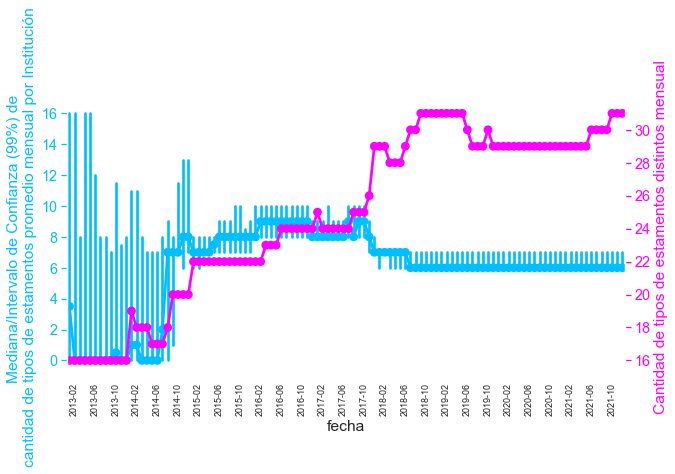

In [162]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 

plt.rc('xtick', labelsize=9) 
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoEstamento', data=tepoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoEstamento', data=tepoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de estamentos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de estamentos distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize), ) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.savefig('fig9.png', bbox_inches = 'tight')
plt.show()

In [163]:
tebox = standar.groupby(by=['OrganismoNombre'])['TipoEstamento'].nunique().reset_index()
tebox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
tebox['qf'] =tebox2['nombre']
tebox['ind']=round(tebox['TipoEstamento']/tebox['qf'], 3)
tebox=tebox[tebox['qf']>50]

In [164]:
tebox.sort_values(by=['ind'], ascending=False).median()

C:\Users\Jose\AppData\Local\Temp\2/ipykernel_20704/4079334570.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tebox.sort_values(by=['ind'], ascending=False).median()


TipoEstamento       7.000
qf               1102.000
ind                 0.008
dtype: float64

In [165]:
teboxS = standar.groupby(by=['TipoEstamento'])['OrganismoNombre'].nunique().reset_index()
display(len(teboxS[teboxS['OrganismoNombre']>=10])/len(teboxS)*100)

80.0

### Tipo Cargo

In [166]:
dftcar = standar[['TipoCargo']].drop_duplicates()
cantTC = len(dftcar)
carClaros = dftcar.sort_values('TipoCargo').head(20)
display(cantTC)
display(carClaros)

437351

,TipoCargo
22522808,(01)Chero
10880706,(1)+I8:L9
19427549,(125) Esc. Nº 1968 Pucara De Lasana
13991603,(131)(26)(51)(37)(43)(46)(08)(09)
6330708,(79)(125)(124)(182)(30) Esc. Nº 1414 Mercedes ...
6373473,(79)(125)(124)(182)(30) Escuela Nº 334 Luis Cr...
6373647,(79)(125)(124)(182)(30)(41) Esc. Nº 1414 Merce...
6207912,(79)(125)(182)(30) Esc. Nº 1414 Mercedes Fonte...
19317691,(79)(125)(182)(30)(41) Esc. Nº 1584 Prof. Mari...
19475329,(79)(125)(30) Liceo Bicentenario


In [167]:
tcpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoCargo'].nunique().reset_index()
tcpoint2 = standar.groupby(by=['fecha'])['TipoCargo'].nunique().reset_index()


In [168]:
tcpoint.tail()

,fecha,OrganismoNombre,TipoCargo
39294,2021-12-01,Superintendencia Del Medio Ambiente (Sma),129
39295,2021-12-01,Tesorería General De La República (Tgr),377
39296,2021-12-01,Unidad De Análisis Financiero,40
39297,2021-12-01,Universidad De Aysén,135
39298,2021-12-01,Universidad De Ohiggins,123


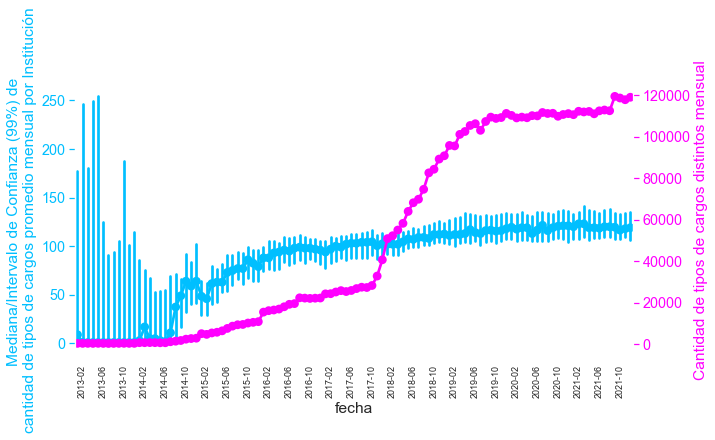

In [169]:
import matplotlib.dates as mdates


plt.rc('xtick', labelsize=9) 
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoCargo', data=tcpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoCargo', data=tcpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de cargos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de cargos distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.savefig('fig10.png', bbox_inches = 'tight')
plt.show()

In [170]:
tcbox = standar.groupby(by=['OrganismoNombre'])['TipoCargo'].nunique().reset_index()
tcbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
tcbox['qf'] =tcbox2['nombre']
tcbox['ind']=round(tcbox['TipoCargo']/tcbox['qf'], 3)
#tcbox=tcbox[tcbox['qf']>50]

In [171]:
tcbox.sort_values(by=['ind'], ascending=False).median()

C:\Users\Jose\AppData\Local\Temp\2/ipykernel_20704/1470660501.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tcbox.sort_values(by=['ind'], ascending=False).median()


TipoCargo    292.000
qf           982.000
ind            0.457
dtype: float64

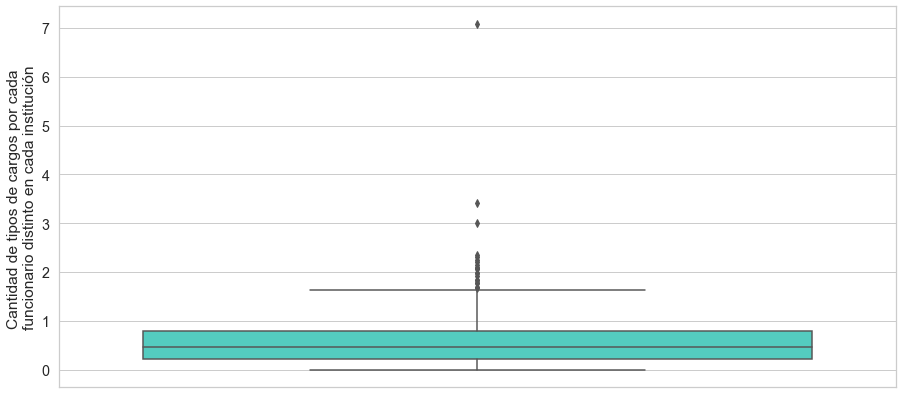

In [173]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=tcbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de cargos por cada \nfuncionario distinto en cada institución')
plt.savefig('fig11.png', bbox_inches = 'tight')
plt.show()

In [174]:
tcbox.sort_values('ind').tail()

,OrganismoNombre,TipoCargo,qf,ind
253,Instituto Nacional De Estadisticas (Ine),7249,3141,2.308
403,Municipalidad De Macul,2160,924,2.338
47,Asociación De Municipios De La Región De Los Ríos,3,1,3.000
576,Seremi De Salud De Valparaíso,7396,2166,3.415
123,Corporación Municipal De Quellón,12337,1740,7.090


In [175]:
tcboxS = standar.groupby(by=['TipoCargo'])['OrganismoNombre'].nunique().reset_index()
display(tcboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(tcboxS[tcboxS['OrganismoNombre']>=10])/len(tcboxS)*100)

,TipoCargo,OrganismoNombre
10915,Administrativo,502
81613,Asistente Social,439
95537,Auxiliar,438
381471,Secretaria,425
122713,Chofer,416


0.404938836172402

## Grados

In [179]:
dfgrados = standar[['GradoEus']].drop_duplicates()
cantG = len(dfgrados)
gClaros = dfgrados.sort_values('GradoEus').head(20)
display(cantG)
display(gClaros)

20988

,GradoEus
7847530,(01)
22417884,(01) Asimilado a Grado
25334861,(102)
25322977,(102)(134)
25322808,(102)(54)
25331964,(102)(54)(134)
25322709,(102)(87)
25325787,(102)(87)(134)
25332233,(102)(87)(54)
25378338,(102)(87)(54)(105)


In [177]:
gpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['GradoEus'].nunique().reset_index()
gpoint2 = standar.groupby(by=['fecha'])['GradoEus'].nunique().reset_index()

In [178]:
gpoint2.tail()

,fecha,GradoEus
103,2021-08-01,3603
104,2021-09-01,4120
105,2021-10-01,3790
106,2021-11-01,3784
107,2021-12-01,3714


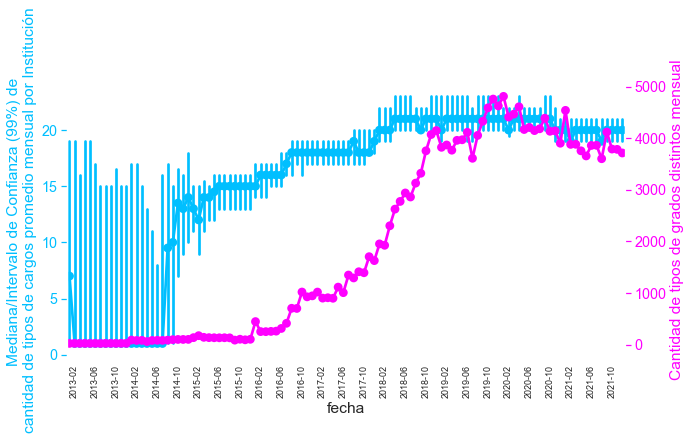

In [180]:
 
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='GradoEus', data=gpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='GradoEus', data=gpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
plt.rc('xtick', labelsize=9)
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de cargos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de grados distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.savefig('fig12.png', bbox_inches = 'tight')
plt.show()

In [181]:
gbox = standar.groupby(by=['OrganismoNombre'])['GradoEus'].nunique().reset_index()
gbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
gbox['qf'] =gbox2['nombre']
gbox['ind']=round(gbox['GradoEus']/gbox['qf'], 4)
gbox=gbox[gbox['qf']>50]

In [182]:
gbox.sort_values(by=['ind'], ascending=False).median()

C:\Users\Jose\AppData\Local\Temp\2/ipykernel_20704/623962151.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gbox.sort_values(by=['ind'], ascending=False).median()


GradoEus      30.0000
qf          1102.0000
ind            0.0422
dtype: float64

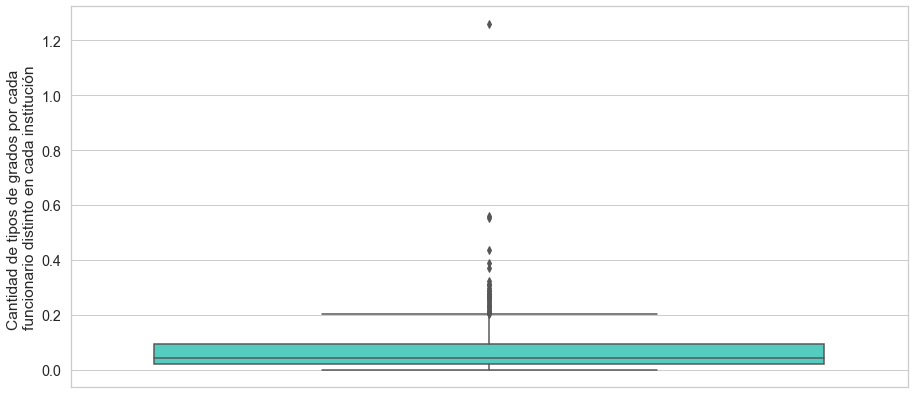

In [184]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=gbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de grados por cada \nfuncionario distinto en cada institución')
plt.savefig('fig13.png', bbox_inches = 'tight')
plt.show()

In [185]:
GboxS = standar.groupby(by=['GradoEus'])['OrganismoNombre'].nunique().reset_index()
display(GboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(GboxS[GboxS['OrganismoNombre']>=10])/len(tcboxS)*100)

,GradoEus,OrganismoNombre
459,12,591
221,10,589
2865,8,588
665,14,586
577,13,584


0.0992340230936321

In [189]:
gbox.sort_values(by=['ind'], ascending=False).head(3)

,OrganismoNombre,GradoEus,qf,ind
432,Municipalidad De Paihuano,1289,1022,1.2613
101,Corporación Municipal De Curaco De Velez,168,301,0.5581
338,Municipalidad De El Quisco,980,1774,0.5524


### Tipo Calificación

In [190]:
calfgrados = standar[['TipoCalificacionp']].drop_duplicates()
cantCal = len(calfgrados)
CalClaros = calfgrados.sort_values('TipoCalificacionp').head()
display(cantCal)
display(CalClaros)

166724

,TipoCalificacionp
7847496,(01)
2652267,(02)
1521343,(07)(33)(51)(12)
1701389,(07)+A45:I46(33)(37)(51)
23159293,(146)(64)(03)(87)(107)(131)


In [194]:
CalClaros = calfgrados.sort_values('TipoCalificacionp').tail(20)
CalClaros

,TipoCalificacionp
26892779,Árbitro Y Mesa De Control Fútbol Y Futsal
26589805,Árbitro Y Oficial De Mesa De Control Basquetbol
27166067,Árbitros
30684126,Área Ambiental Agripecuario
24321531,Área De Convivencia
30721974,Área De La Construcción
24217844,Área De Participación
31051924,Área Informatica
30508597,Área Informática
30877431,Áreas De Servicios


In [191]:
calpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoCalificacionp'].nunique().reset_index()
calpoint2 = standar.groupby(by=['fecha'])['TipoCalificacionp'].nunique().reset_index()

In [192]:
calpoint2.tail()

,fecha,TipoCalificacionp
103,2021-08-01,39150
104,2021-09-01,39229
105,2021-10-01,39211
106,2021-11-01,39642
107,2021-12-01,39520


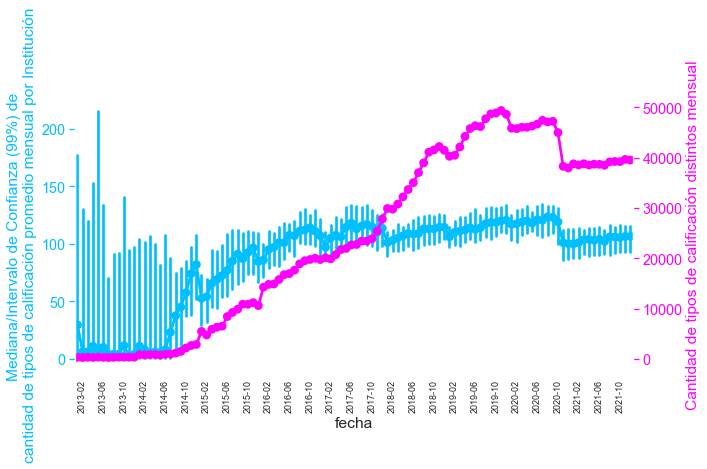

In [195]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoCalificacionp', data=calpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoCalificacionp', data=calpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de calificación promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de calificación distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.savefig('fig14.png', bbox_inches = 'tight')
plt.show()

In [196]:
calbox = standar.groupby(by=['OrganismoNombre'])['TipoCalificacionp'].nunique().reset_index()
calbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
calbox['qf'] =calbox2['nombre']
calbox['ind']=round(calbox['TipoCalificacionp']/calbox['qf'], 4)
calbox=calbox[calbox['qf']>50]

In [197]:
calbox.sort_values(by=['ind'], ascending=False).median()

C:\Users\Jose\AppData\Local\Temp\2/ipykernel_20704/3318289985.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  calbox.sort_values(by=['ind'], ascending=False).median()


TipoCalificacionp     316.0000
qf                   1102.0000
ind                     0.3786
dtype: float64

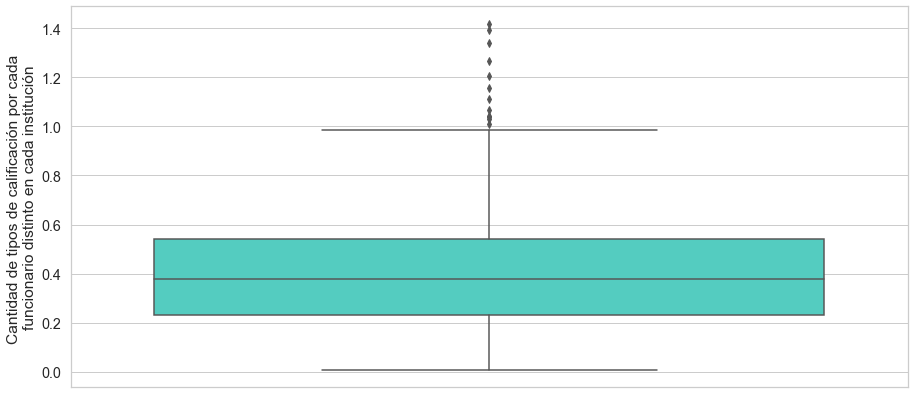

In [198]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=calbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de calificación por cada \nfuncionario distinto en cada institución')
plt.savefig('fig15.png', bbox_inches = 'tight')
plt.show()

In [199]:
calboxS = standar.groupby(by=['TipoCalificacionp'])['OrganismoNombre'].nunique().reset_index()
display(calboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(calboxS[calboxS['OrganismoNombre']>=10])/len(tcboxS)*100)
display((len(calboxS[calboxS['OrganismoNombre']>=10])))

,TipoCalificacionp,OrganismoNombre
61164,Ingeniero Comercial,628
2134,Abogado,623
22236,Contador Auditor,620
13627,Asistente Social,620
91520,Periodista,571


0.7394535269235166

3234

In [202]:
calbox.sort_values(by=['ind'], ascending=False).head(5)

,OrganismoNombre,TipoCalificacionp,qf,ind
299,Municipalidad De Chile Chico,995,701,1.4194
463,Municipalidad De Pudahuel,904,648,1.3951
253,Instituto Nacional De Estadisticas (Ine),4214,3141,1.3416
3,Agencia De Promoción De La Inversión Extranjera,109,86,1.2674
182,Gobierno Regional De Los Ríos (Gore De Los Ríos),217,180,1.2056
